## The Siamese BiLSTM Architecture

Text similarity using Siamese BiLSTM is like having a filter helping you figure out how much two pieces of text resemble each other. It's handy for spotting duplicates or identifying sentences that convey the same idea.

**Text Similarity:** This refers to the degree to which two pieces of text are alike or resemble each other in meaning or content.

**Siamese BiLSTM:** This is a type of neural network architecture that utilizes Long Short-Term Memory (LSTM) units in a bidirectional (Bi) manner. Siamese networks have two identical subnetworks that share the same weights and architecture, and they process two different inputs simultaneously.

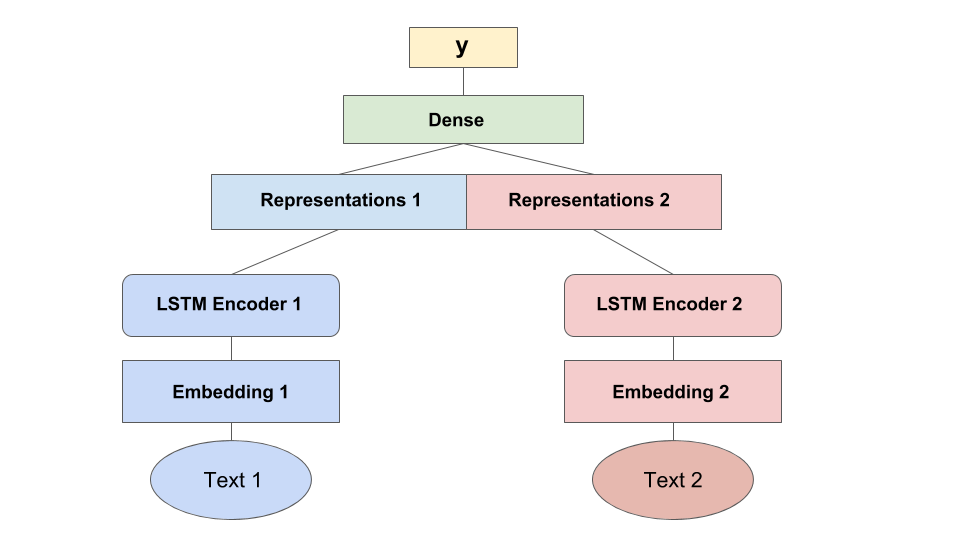

### Table of Contents
1. [Data Preparation](#data-preparation)
2. [Word Embedding](#word-embedding)
3. [Model Training](#model-training)
4. [Model Evaluation](#model-evaluation)
5. [Conclusion](#conclusion)

First things first, let's bring in the tools we need.

In [24]:
!pip install keras pandas gensim tensorflow tensorboard

#### model
This holds the blueprint for our Siamese BiLSTM model. It's like the architect's plan for our smart text comparer.


In [25]:
# keras imports
from keras.layers import Dense, Input, LSTM, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Embedding
from keras.layers import concatenate
from keras.callbacks import TensorBoard
from keras.models import load_model
from keras.models import Model

# std imports
import time
import gc
import os


class SiameseBiLSTM:
    def __init__(self, embedding_dim, max_sequence_length, number_lstm, number_dense, rate_drop_lstm, 
                 rate_drop_dense, hidden_activation, validation_split_ratio):
        self.embedding_dim = embedding_dim
        self.max_sequence_length = max_sequence_length
        self.number_lstm_units = number_lstm
        self.rate_drop_lstm = rate_drop_lstm
        self.number_dense_units = number_dense
        self.activation_function = hidden_activation
        self.rate_drop_dense = rate_drop_dense
        self.validation_split_ratio = validation_split_ratio

    def train_model(self, sentences_pair, is_similar, embedding_meta_data, model_save_directory='./'):
        """
        Train Siamese network to find similarity between sentences in `sentences_pair`
            Steps Involved:
                1. Pass the each from sentences_pairs  to bidirectional LSTM encoder.
                2. Merge the vectors from LSTM encodes and passed to dense layer.
                3. Pass the  dense layer vectors to sigmoid output layer.
                4. Use cross entropy loss to train weights
        Args:
            sentences_pair (list): list of tuple of sentence pairs
            is_similar (list): target value 1 if same sentences pair are similar otherwise 0
            embedding_meta_data (dict): dict containing tokenizer and word embedding matrix
            model_save_directory (str): working directory for where to save models

        Returns:
            return (best_model_path):  path of best model
        """
        tokenizer, embedding_matrix = embedding_meta_data['tokenizer'], embedding_meta_data['embedding_matrix']

        train_data_x1, train_data_x2, train_labels, leaks_train, \
        val_data_x1, val_data_x2, val_labels, leaks_val = create_train_dev_set(tokenizer, sentences_pair,
                                                                               is_similar, self.max_sequence_length,
                                                                               self.validation_split_ratio)

        if train_data_x1 is None:
            print("++++ !! Failure: Unable to train model ++++")
            return None

        nb_words = len(tokenizer.word_index) + 1

        # Creating word embedding layer
        embedding_layer = Embedding(nb_words, self.embedding_dim, weights=[embedding_matrix],
                                    input_length=self.max_sequence_length, trainable=False)

        # Creating LSTM Encoder
        lstm_layer = Bidirectional(LSTM(self.number_lstm_units, dropout=self.rate_drop_lstm, recurrent_dropout=self.rate_drop_lstm))

        # Creating LSTM Encoder layer for First Sentence
        sequence_1_input = Input(shape=(self.max_sequence_length,), dtype='int32')
        embedded_sequences_1 = embedding_layer(sequence_1_input)
        x1 = lstm_layer(embedded_sequences_1)

        # Creating LSTM Encoder layer for Second Sentence
        sequence_2_input = Input(shape=(self.max_sequence_length,), dtype='int32')
        embedded_sequences_2 = embedding_layer(sequence_2_input)
        x2 = lstm_layer(embedded_sequences_2)

        # Creating leaks input
        leaks_input = Input(shape=(leaks_train.shape[1],))
        leaks_dense = Dense(int(self.number_dense_units/2), activation=self.activation_function)(leaks_input)

        # Merging two LSTM encodes vectors from sentences to
        # pass it to dense layer applying dropout and batch normalisation
        merged = concatenate([x1, x2, leaks_dense])
        merged = BatchNormalization()(merged)
        merged = Dropout(self.rate_drop_dense)(merged)
        merged = Dense(self.number_dense_units, activation=self.activation_function)(merged)
        merged = BatchNormalization()(merged)
        merged = Dropout(self.rate_drop_dense)(merged)
        preds = Dense(1, activation='sigmoid')(merged)

        model = Model(inputs=[sequence_1_input, sequence_2_input, leaks_input], outputs=preds)
        model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])

        early_stopping = EarlyStopping(monitor='val_loss', patience=3)

        STAMP = 'lstm_%d_%d_%.2f_%.2f' % (self.number_lstm_units, self.number_dense_units, self.rate_drop_lstm, self.rate_drop_dense)

        checkpoint_dir = model_save_directory + 'checkpoints/' + str(int(time.time())) + '/'

        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)

        bst_model_path = checkpoint_dir + STAMP + '.h5'

        model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=False)

        tensorboard = TensorBoard(log_dir=checkpoint_dir + "logs/{}".format(time.time()))

        model.fit([train_data_x1, train_data_x2, leaks_train], train_labels,
                  validation_data=([val_data_x1, val_data_x2, leaks_val], val_labels),
                  epochs=200, batch_size=64, shuffle=True,
                  callbacks=[early_stopping, model_checkpoint, tensorboard])

        return bst_model_path


    def update_model(self, saved_model_path, new_sentences_pair, is_similar, embedding_meta_data):
        """
        Update trained siamese model for given new sentences pairs 
            Steps Involved:
                1. Pass the each from sentences from new_sentences_pair to bidirectional LSTM encoder.
                2. Merge the vectors from LSTM encodes and passed to dense layer.
                3. Pass the  dense layer vectors to sigmoid output layer.
                4. Use cross entropy loss to train weights
        Args:
            model_path (str): model path of already trained siamese model
            new_sentences_pair (list): list of tuple of new sentences pairs
            is_similar (list): target value 1 if same sentences pair are similar otherwise 0
            embedding_meta_data (dict): dict containing tokenizer and word embedding matrix

        Returns:
            return (best_model_path):  path of best model
        """
        tokenizer = embedding_meta_data['tokenizer']
        train_data_x1, train_data_x2, train_labels, leaks_train, \
        val_data_x1, val_data_x2, val_labels, leaks_val = create_train_dev_set(tokenizer, new_sentences_pair,
                                                                               is_similar, self.max_sequence_length,
                                                                               self.validation_split_ratio)
        model = load_model(saved_model_path)
        model_file_name = saved_model_path.split('/')[-1]
        new_model_checkpoint_path  = saved_model_path.split('/')[:-2] + str(int(time.time())) + '/' 

        new_model_path = new_model_checkpoint_path + model_file_name
        model_checkpoint = ModelCheckpoint(new_model_checkpoint_path + model_file_name,
                                           save_best_only=True, save_weights_only=False)

        early_stopping = EarlyStopping(monitor='val_loss', patience=3)

        tensorboard = TensorBoard(log_dir=new_model_checkpoint_path + "logs/{}".format(time.time()))

        model.fit([train_data_x1, train_data_x2, leaks_train], train_labels,
                  validation_data=([val_data_x1, val_data_x2, leaks_val], val_labels),
                  epochs=50, batch_size=3, shuffle=True,
                  callbacks=[early_stopping, model_checkpoint, tensorboard])

        return new_model_path

#### inputHandler
Here's where we handle all the data preprocessing tasks. Think of it as preparing the ingredients before cooking.

In [26]:
from keras.utils import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from gensim.models import Word2Vec
import numpy as np
import gc


def train_word2vec(documents, embedding_dim):
    """
    train word2vector over traning documents
    Args:
        documents (list): list of document
        embedding_dim (int): outpu wordvector size
    Returns:
        word_vectors(dict): dict containing words and their respective vectors
    """
    model = Word2Vec(documents, min_count=1, vector_size=embedding_dim)
    word_vectors = model.wv
    del model
    return word_vectors


def create_embedding_matrix(tokenizer, word_vectors, embedding_dim):
    """
    Create embedding matrix containing word indexes and respective vectors from word vectors
    Args:
        tokenizer (keras.preprocessing.text.Tokenizer): keras tokenizer object containing word indexes
        word_vectors (dict): dict containing word and their respective vectors
        embedding_dim (int): dimention of word vector

    Returns:

    """
    nb_words = len(tokenizer.word_index) + 1
    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((nb_words, embedding_dim))
    print("Embedding matrix shape: %s" % str(embedding_matrix.shape))
    for word, i in word_index.items():
        try:
            embedding_vector = word_vectors[word]
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
        except KeyError:
            print("vector not found for word - %s" % word)
    print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
    return embedding_matrix


def word_embed_meta_data(documents, embedding_dim):
    """
    Load tokenizer object for given vocabs list
    Args:
        documents (list): list of document
        embedding_dim (int): embedding dimension
    Returns:
        tokenizer (keras.preprocessing.text.Tokenizer): keras tokenizer object
        embedding_matrix (dict): dict with word_index and vector mapping
    """
    documents = [x.lower().split() for x in documents]
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(documents)
    word_vector = train_word2vec(documents, embedding_dim)
    embedding_matrix = create_embedding_matrix(tokenizer, word_vector, embedding_dim)
    del word_vector
    gc.collect()
    return tokenizer, embedding_matrix


def create_train_dev_set(tokenizer, sentences_pair, is_similar, max_sequence_length, validation_split_ratio):
    """
    Create training and validation dataset
    Args:
        tokenizer (keras.preprocessing.text.Tokenizer): keras tokenizer object
        sentences_pair (list): list of tuple of sentences pairs
        is_similar (list): list containing labels if respective sentences in sentence1 and sentence2
                           are same or not (1 if same else 0)
        max_sequence_length (int): max sequence length of sentences to apply padding
        validation_split_ratio (float): contain ratio to split training data into validation data

    Returns:
        train_data_1 (list): list of input features for training set from sentences1
        train_data_2 (list): list of input features for training set from sentences2
        labels_train (np.array): array containing similarity score for training data
        leaks_train(np.array): array of training leaks features

        val_data_1 (list): list of input features for validation set from sentences1
        val_data_2 (list): list of input features for validation set from sentences1
        labels_val (np.array): array containing similarity score for validation data
        leaks_val (np.array): array of validation leaks features
    """
    sentences1 = [x[0].lower() for x in sentences_pair]
    sentences2 = [x[1].lower() for x in sentences_pair]
    train_sequences_1 = tokenizer.texts_to_sequences(sentences1)
    train_sequences_2 = tokenizer.texts_to_sequences(sentences2)
    leaks = [[len(set(x1)), len(set(x2)), len(set(x1).intersection(x2))]
             for x1, x2 in zip(train_sequences_1, train_sequences_2)]

    train_padded_data_1 = pad_sequences(train_sequences_1, maxlen=max_sequence_length)
    train_padded_data_2 = pad_sequences(train_sequences_2, maxlen=max_sequence_length)
    train_labels = np.array(is_similar)
    leaks = np.array(leaks)

    shuffle_indices = np.random.permutation(np.arange(len(train_labels)))
    train_data_1_shuffled = train_padded_data_1[shuffle_indices]
    train_data_2_shuffled = train_padded_data_2[shuffle_indices]
    train_labels_shuffled = train_labels[shuffle_indices]
    leaks_shuffled = leaks[shuffle_indices]

    dev_idx = max(1, int(len(train_labels_shuffled) * validation_split_ratio))

    del train_padded_data_1
    del train_padded_data_2
    gc.collect()

    train_data_1, val_data_1 = train_data_1_shuffled[:-dev_idx], train_data_1_shuffled[-dev_idx:]
    train_data_2, val_data_2 = train_data_2_shuffled[:-dev_idx], train_data_2_shuffled[-dev_idx:]
    labels_train, labels_val = train_labels_shuffled[:-dev_idx], train_labels_shuffled[-dev_idx:]
    leaks_train, leaks_val = leaks_shuffled[:-dev_idx], leaks_shuffled[-dev_idx:]

    return train_data_1, train_data_2, labels_train, leaks_train, val_data_1, val_data_2, labels_val, leaks_val


def create_test_data(tokenizer, test_sentences_pair, max_sequence_length):
    """
    Create training and validation dataset
    Args:
        tokenizer (keras.preprocessing.text.Tokenizer): keras tokenizer object
        test_sentences_pair (list): list of tuple of sentences pairs
        max_sequence_length (int): max sequence length of sentences to apply padding

    Returns:
        test_data_1 (list): list of input features for training set from sentences1
        test_data_2 (list): list of input features for training set from sentences2
    """
    test_sentences1 = [x[0].lower() for x in test_sentences_pair]
    test_sentences2 = [x[1].lower() for x in test_sentences_pair]

    test_sequences_1 = tokenizer.texts_to_sequences(test_sentences1)
    test_sequences_2 = tokenizer.texts_to_sequences(test_sentences2)
    leaks_test = [[len(set(x1)), len(set(x2)), len(set(x1).intersection(x2))]
                  for x1, x2 in zip(test_sequences_1, test_sequences_2)]

    leaks_test = np.array(leaks_test)
    test_data_1 = pad_sequences(test_sequences_1, maxlen=max_sequence_length)
    test_data_2 = pad_sequences(test_sequences_2, maxlen=max_sequence_length)

    return test_data_1, test_data_2, leaks_test

#### config
These are our settings. It stores all the important parameters for our model, like the size of word embeddings and the number of LSTM units.

In [27]:
EMBEDDING_DIM = 50

MAX_SEQUENCE_LENGTH = 10
VALIDATION_SPLIT = 0.1


RATE_DROP_LSTM = 0.17
RATE_DROP_DENSE = 0.25
NUMBER_LSTM = 50
NUMBER_DENSE_UNITS = 50
ACTIVATION_FUNCTION = 'relu'


siamese_config = {
	'EMBEDDING_DIM': EMBEDDING_DIM,
	'MAX_SEQUENCE_LENGTH' : MAX_SEQUENCE_LENGTH,
	'VALIDATION_SPLIT': VALIDATION_SPLIT,
	'RATE_DROP_LSTM': RATE_DROP_LSTM,
	'RATE_DROP_DENSE': RATE_DROP_DENSE,
	'NUMBER_LSTM': NUMBER_LSTM,
	'NUMBER_DENSE_UNITS': NUMBER_DENSE_UNITS,
	'ACTIVATION_FUNCTION': ACTIVATION_FUNCTION
}

In [28]:
from operator import itemgetter
from keras.models import load_model
import pandas as pd

### 1. Data Preparation <a id="data-preparation"></a>
Loading the Dataset.

### Dataset Background
The dataset available has been generated by ChatGPT (AI Bot) using the following prompt:

"Give me more CSV sentences like this:

| Sentences1               | Sentences2                       | Is_Similar |
|--------------------------|----------------------------------|------------|
| I had a bad day          | I had so much fun                | 0          |
| I had a bad day          | Everything was terrible today    | 1          |"

This dataset serves as a fundamental resource for studying sentence similarity. It consists of pairs of sentences along with a binary label indicating whether the sentences are similar or not. The sentences vary in their content and sentiment, providing a diverse set for analysis and modeling. The objective is to leverage this dataset to develop our model capable of accurately determining semantic similarity between arbitrary pairs of sentences.

In [29]:
df = pd.read_csv('dataset/sentences.csv')

In [30]:
df

,sentences1,sentences2,is_similar
0,The sun is shining brightly,It's a beautiful day outside,1
1,The sun is shining brightly,It's pouring rain,0
2,I love chocolate ice cream,Vanilla is my favorite flavor,0
3,I love chocolate ice cream,Chocolate is the best,1
4,The cat is sleeping peacefully,The dog is barking loudly,0
...,...,...,...
186,I enjoy playing musical instruments,I'm not musically inclined,0
187,I enjoy playing musical instruments,Music is a universal language,1
188,I prefer watching TV shows over movies,Movies are too long for me,0
189,I prefer watching TV shows over movies,TV shows offer episodic entertainment,1


In [31]:
sentences1 = list(df['sentences1'])
sentences2 = list(df['sentences2'])
is_similar = list(df['is_similar'])
del df

### 2. Word Embedding <a id="word-embedding"></a>

Next, we'll create word embedding metadata for the sentences and prepare the data for training.

We're converting our sentences into embeddings, which are numeric representations of words. This step helps our model understand the meaning of words in a mathematical way.

In [32]:
tokenizer, embedding_matrix = word_embed_meta_data(sentences1 + sentences2,  siamese_config['EMBEDDING_DIM'])

Embedding matrix shape: (624, 50)
Null word embeddings: 1


In [33]:
embedding_meta_data = {
	'tokenizer': tokenizer,
	'embedding_matrix': embedding_matrix
}

In [34]:
sentences_pair = [(x1, x2) for x1, x2 in zip(sentences1, sentences2)]
del sentences1
del sentences2

### 3. Model Training <a id="model-training"></a>

Now comes the fun part – training our Siamese BiLSTM model.

We're defining the model's architecture and training it using our prepared data. Once trained, we save the best-performing model.

In [35]:
class Configuration(object):
    """Dump stuff here"""

In [36]:
CONFIG = Configuration()
CONFIG.embedding_dim = siamese_config['EMBEDDING_DIM']
CONFIG.max_sequence_length = siamese_config['MAX_SEQUENCE_LENGTH']
CONFIG.number_lstm_units = siamese_config['NUMBER_LSTM']
CONFIG.rate_drop_lstm = siamese_config['RATE_DROP_LSTM']
CONFIG.number_dense_units = siamese_config['NUMBER_DENSE_UNITS']
CONFIG.activation_function = siamese_config['ACTIVATION_FUNCTION']
CONFIG.rate_drop_dense = siamese_config['RATE_DROP_DENSE']
CONFIG.validation_split_ratio = siamese_config['VALIDATION_SPLIT']

In [37]:
siamese = SiameseBiLSTM(CONFIG.embedding_dim , CONFIG.max_sequence_length, CONFIG.number_lstm_units , CONFIG.number_dense_units, 
					    CONFIG.rate_drop_lstm, CONFIG.rate_drop_dense, CONFIG.activation_function, CONFIG.validation_split_ratio)

In [38]:
best_model_path = siamese.train_model(sentences_pair, is_similar, embedding_meta_data, model_save_directory='./')

c:\Users\Mubashir.Ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 17s 9s/step - acc: 0.5781 - loss: 0.7915

3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 558ms/step - acc: 0.5477 - loss: 0.8137 - val_acc: 0.4737 - val_loss: 0.6963
Epoch 2/200
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - acc: 0.5088 - loss: 0.8847 - val_acc: 0.4737 - val_loss: 0.6975
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - acc: 0.5088 - loss: 0.8847 - val_acc: 0.4737 - val_loss: 0.6975
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - acc: 0.5379 - loss: 0.8759 - val_acc: 0.4737 - val_loss: 0.6995
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - acc: 0.5379 - loss: 0.8759 - val_acc: 0.4737 - val_loss: 0.6995
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - acc: 0.5389 - loss: 0.7915 - val_acc: 0.4737 - val_loss: 0.7014
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - acc: 0.5389 - loss: 0.7915 - val_acc: 0.4737 - val_loss: 0.7014


### 4. Model Evaluation <a id="model-evaluation"></a>

Let's see how well our model performs!

We're loading the trained model and using it to compute similarity scores for sample sentences. This helps us gauge how effective our model is at comparing text.

In [39]:
model = load_model(best_model_path)

In [40]:
def compute_similarity(s1 , s2):
    
    test_sentence_pairs = [(s1,s2)]
    test_data_x1, test_data_x2, leaks_test = create_test_data(tokenizer,test_sentence_pairs,  siamese_config['MAX_SEQUENCE_LENGTH'])
    preds = list(model.predict([test_data_x1, test_data_x2, leaks_test], verbose=1).ravel())
    results = [(x, y, z) for (x, y), z in zip(test_sentence_pairs, preds)]
    results.sort(key=itemgetter(2), reverse=True)
    
    return results[0][-1]

In [41]:
sim_score1 = compute_similarity("I had a bad day", "I had so much fun")
sim_score2 = compute_similarity("I had a bad day", "Everything was terrible today")

print("Similarity score 1:" , sim_score1)
print("Similarity score 2:" , sim_score2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Similarity score 1: 0.49218944
Similarity score 2: 0.50031495


In [42]:
sim_score2 > sim_score1

True

### 5. Conclusion <a id="conclusion"></a>

And that's a wrap!

#### Current Results
Our Siamese BiLSTM model achieved similarity scores of ~0.49-0.50 for both similar and dissimilar sentence pairs, indicating the model hasn't learned to distinguish between them effectively.

#### Current Shortcomings
1. **Insufficient Training Data**: Only 193 sentence pairs (need 1,000+ for deep learning)
2. **Poor Model Performance**: Validation accuracy of ~47% (close to random guessing)
3. **Early Training Termination**: Model stopped after 4 epochs due to overfitting
4. **Inadequate Word Embeddings**: Word2Vec trained on small dataset lacks semantic richness

#### Future Improvements
1. **Expand Dataset**: Collect 1,000-10,000 diverse sentence pairs
2. **Use Pre-trained Embeddings**: Leverage GloVe, Word2Vec, or BERT embeddings
3. **Model Simplification**: Reduce LSTM/dense units for smaller datasets
4. **Advanced Architectures**: Implement SentenceTransformers or BERT-based similarity
5. **Data Augmentation**: Generate synthetic training examples
6. **Hyperparameter Tuning**: Optimize learning rate, batch size, and architecture

#### Key Takeaway
While the Siamese BiLSTM architecture is theoretically sound, its effectiveness depends heavily on data quality and quantity. For production use, consider pre-trained sentence similarity models that require minimal fine-tuning.